In [ ]:
import pandas as pd

df1 = pd.read_csv(
    'signal_compressed_total.csv',
    usecols=[1,2,3],         
    skiprows=1,                
    header=None,
    names=['Tracheal','Mic','nasal','resp']
)[['Mic','nasal','resp']]

print(f"Base rows: {len(df1)}")

noise_types = ['fan', 'heater', 'rain', 'white_noise']

for src in noise_types:
    noise_df = pd.read_csv(
        f'{src}_db_norm.csv',
        usecols=[1],       
        skiprows=1,       
        header=None,
        names=[f'{src}_dBFS_norm'],
        nrows=len(df1)    
    )

    print(f"{src}: noise rows = {len(noise_df)}")

    df = pd.concat(
        [df1.reset_index(drop=True),
         noise_df.reset_index(drop=True)],
        axis=1
    )
    df[f'Mic_plus_{src}'] = df['Mic'] + df[f'{src}_dBFS_norm']

    out = df[[f'Mic_plus_{src}', 'nasal', 'resp']]
    out.to_csv(f'Mic_plus_{src}.csv', index=False)

    print(f"→ saved Mic_plus_{src}.csv ({out.shape[0]} rows)")


Base rows: 17891
fan: noise rows = 17891
→ saved Mic_plus_fan.csv (17891 rows)
heater: noise rows = 17891
→ saved Mic_plus_heater.csv (17891 rows)
rain: noise rows = 17891
→ saved Mic_plus_rain.csv (17891 rows)
white_noise: noise rows = 17891
→ saved Mic_plus_white_noise.csv (17891 rows)


In [ ]:
out_df = df[['Mic_plus_dBFS', 'nasal', 'resp']]

out_df.to_csv('Mic_plusBFS.csv', index=False)

print(out_df.head())

   Mic_plus_dBFS  nasal  resp
0      -0.077517    0.0   0.0
1       1.513987    0.0   0.0
2      -0.076213    0.0   0.0
3       0.014562    0.0   0.0
4       0.059432    0.0   0.0


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

class SignalDataset(Dataset):
    def __init__(self, df, seq_len, feature_col):
        self.X       = df[[feature_col]].values.astype('float32')  
        self.n       = df['nasal_lbl'].values.astype('int64')      
        self.r       = df['resp_lbl'].values.astype('int64')      
        self.seq_len = seq_len

    def __len__(self):
        return max(len(self.X) - self.seq_len + 1, 0)

    def __getitem__(self, idx):
        x_seq = self.X[idx:idx+self.seq_len]  
        n_seq = self.n[idx:idx+self.seq_len]
        r_seq = self.r[idx:idx+self.seq_len]
        return (
            torch.from_numpy(x_seq), 
            torch.from_numpy(n_seq),
            torch.from_numpy(r_seq),
        )

class CNN_GRU_Multi(nn.Module):
    def __init__(self, input_dim=1, cnn_hidden=256, cnn_layers=16, kernel_size=3,
                 gru_hidden=256, gru_layers=16, bidirectional=True, num_classes=2):
        super().__init__()
        blocks, in_ch = [], input_dim
        for _ in range(cnn_layers):
            blocks += [
                nn.Conv1d(in_ch, cnn_hidden, kernel_size, padding=kernel_size//2),
                nn.BatchNorm1d(cnn_hidden),
                nn.ReLU(inplace=True),
                nn.Dropout(0.1),
            ]
            in_ch = cnn_hidden
        self.cnn = nn.Sequential(*blocks)

        self.gru = nn.GRU(
            cnn_hidden, gru_hidden, gru_layers,
            batch_first=True, bidirectional=bidirectional
        )
        out_dim = gru_hidden * (2 if bidirectional else 1)

        self.head_n = nn.Linear(out_dim, num_classes)
        self.head_r = nn.Linear(out_dim, num_classes)

    def forward(self, x):
        h = x.permute(0,2,1)
        h = self.cnn(h)           
        h = h.permute(0,2,1)     
        o, _ = self.gru(h)       
        return self.head_n(o), self.head_r(o)

seq_len  = 50
batch_sz = 128
lr       = 1e-3
n_epochs = 30
device   = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

noise_types = ['fan', 'heater', 'rain', 'white_noise']

for noise in noise_types:
    print(f"\n===== Training on Mic_plus_{noise}.csv =====")
    feature_col = f'Mic_plus_{noise}'

    df = pd.read_csv(f'Mic_plus_{noise}.csv')
    df['nasal_lbl'] = (df['nasal'] > 0.5).astype('int64')
    df['resp_lbl']  = (df['resp']  > 0.5).astype('int64')

    train_df, val_df = train_test_split(
        df, test_size=0.2, random_state=42,
        stratify=df['nasal_lbl']
    )
    train_df = train_df.reset_index(drop=True)
    val_df   = val_df.reset_index(drop=True)

    train_ds = SignalDataset(train_df, seq_len, feature_col)
    val_ds   = SignalDataset(val_df,   seq_len, feature_col)
    train_loader = DataLoader(train_ds, batch_size=batch_sz, shuffle=True,  drop_last=True)
    val_loader   = DataLoader(val_ds,   batch_size=batch_sz, shuffle=False, drop_last=False)

    model = CNN_GRU_Multi(input_dim=1).to(device)
    n_counts = np.bincount(train_df['nasal_lbl'])
    r_counts = np.bincount(train_df['resp_lbl'])
    w_n = torch.tensor([(n_counts.sum()/(2*n_counts[i])) for i in [0,1]],
                       dtype=torch.float, device=device)
    w_r = torch.tensor([(r_counts.sum()/(2*r_counts[i])) for i in [0,1]],
                       dtype=torch.float, device=device)

    crit_n = nn.CrossEntropyLoss(weight=w_n)
    crit_r = nn.CrossEntropyLoss(weight=w_r)
    opt    = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    sched  = ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=3)

    for epoch in range(1, n_epochs+1):
        model.train()
        tot_n = tot_r = total = 0.0
        for x_b, n_b, r_b in train_loader:
            B, T, _ = x_b.shape
            x = x_b.to(device)
            n = n_b.to(device)
            r = r_b.to(device)

            ln, lr_ = model(x)
            loss_n  = crit_n(ln.reshape(-1,2), n.reshape(-1))
            loss_r  = crit_r(lr_.reshape(-1,2), r.reshape(-1))
            loss    = loss_n + loss_r

            opt.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 0.5)
            opt.step()

            tot_n  += loss_n.item() * B * T
            tot_r  += loss_r.item() * B * T
            total  += B * T

        train_n_ce = tot_n/total
        train_r_ce = tot_r/total

        model.eval()
        val_n = val_r = vtotal = correct_n = correct_r = 0.0
        with torch.no_grad():
            for x_b, n_b, r_b in val_loader:
                B, T, _ = x_b.shape
                x = x_b.to(device)
                n = n_b.to(device)
                r = r_b.to(device)

                ln, lr_ = model(x)
                val_n  += crit_n(ln.reshape(-1,2), n.reshape(-1)).item() * B * T
                val_r  += crit_r(lr_.reshape(-1,2), r.reshape(-1)).item() * B * T
                vtotal += B * T

                preds_n = ln.argmax(-1)
                preds_r = lr_.argmax(-1)
                correct_n += (preds_n == n).sum().item()
                correct_r += (preds_r == r).sum().item()

        val_n_ce = val_n/vtotal
        val_r_ce = val_r/vtotal
        acc_n    = correct_n/vtotal*100
        acc_r    = correct_r/vtotal*100

        sched.step(val_n_ce + val_r_ce)
        lr_now = opt.param_groups[0]['lr']

        print(
            f"[{noise}] Epoch {epoch:02d}/{n_epochs}: "
            f"TnCE={train_n_ce:.4f}, TrCE={train_r_ce:.4f} | "
            f"VnCE={val_n_ce:.4f}, VnAcc={acc_n:.1f}% | "
            f"VrCE={val_r_ce:.4f}, VrAcc={acc_r:.1f}% | "
            f"LR={lr_now:.1e}"
        )

    torch.save(model.state_dict(), f'cnn_gru_multi_{noise}.pth')
    print(f"→ Saved model cnn_gru_multi_{noise}.pth\n")



===== Training on Mic_plus_fan.csv =====
[fan] Epoch 01/30: TnCE=0.7037, TrCE=0.7095 | VnCE=0.6960, VnAcc=25.0% | VrCE=0.6939, VrAcc=29.6% | LR=1.0e-03
[fan] Epoch 02/30: TnCE=0.6904, TrCE=0.6930 | VnCE=0.6928, VnAcc=90.9% | VrCE=0.6933, VrAcc=77.6% | LR=1.0e-03
[fan] Epoch 03/30: TnCE=0.6915, TrCE=0.6930 | VnCE=0.6939, VnAcc=16.0% | VrCE=0.6934, VrAcc=83.7% | LR=1.0e-03
[fan] Epoch 04/30: TnCE=0.6913, TrCE=0.6930 | VnCE=0.6919, VnAcc=26.0% | VrCE=0.6947, VrAcc=29.2% | LR=1.0e-03
[fan] Epoch 05/30: TnCE=0.6912, TrCE=0.6931 | VnCE=0.6927, VnAcc=65.2% | VrCE=0.6930, VrAcc=81.1% | LR=1.0e-03
[fan] Epoch 06/30: TnCE=0.6915, TrCE=0.6929 | VnCE=0.6938, VnAcc=21.7% | VrCE=0.6933, VrAcc=83.7% | LR=1.0e-03
[fan] Epoch 07/30: TnCE=0.6909, TrCE=0.6929 | VnCE=0.6923, VnAcc=89.6% | VrCE=0.6932, VrAcc=83.7% | LR=1.0e-03
[fan] Epoch 08/30: TnCE=0.6906, TrCE=0.6930 | VnCE=0.6955, VnAcc=70.4% | VrCE=0.6930, VrAcc=75.0% | LR=1.0e-03
[fan] Epoch 09/30: TnCE=0.6903, TrCE=0.6930 | VnCE=0.6926, VnAcc=78.3%

In [28]:
torch.save(model.state_dict(), 'cnn_gru_multi.pth')

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np

class SignalDataset(Dataset):
    def __init__(self, df: pd.DataFrame, seq_len: int):
        self.X       = df[['Mic_plus_dBFS']].values.astype('float32')  # (T,1)
        self.seq_len = seq_len

    def __len__(self):
        return max(len(self.X) - self.seq_len + 1, 0)

    def __getitem__(self, idx):
        x_seq = self.X[idx:idx+self.seq_len]
        return torch.from_numpy(x_seq)

class CNN_GRU_Multi(nn.Module):
    def __init__(self,
                 input_dim=1,
                 cnn_hidden=256,
                 cnn_layers=16,
                 kernel_size=3,
                 gru_hidden=256,
                 gru_layers=16,
                 bidirectional=True,
                 num_classes=2):
        super().__init__()
        blocks, in_ch = [], input_dim
        for _ in range(cnn_layers):
            blocks += [
                nn.Conv1d(in_ch, cnn_hidden, kernel_size, padding=kernel_size//2),
                nn.BatchNorm1d(cnn_hidden),
                nn.ReLU(inplace=True),
                nn.Dropout(0.1),
            ]
            in_ch = cnn_hidden
        self.cnn = nn.Sequential(*blocks)

        self.gru = nn.GRU(
            cnn_hidden, gru_hidden, gru_layers,
            batch_first=True, bidirectional=bidirectional
        )
        out_dim = gru_hidden * (2 if bidirectional else 1)

        self.head_n = nn.Linear(out_dim, num_classes)
        self.head_r = nn.Linear(out_dim, num_classes)

    def forward(self, x):
        h = x.permute(0,2,1)           
        h = self.cnn(h)               
        h = h.permute(0,2,1)         
        o, _ = self.gru(h)             
        return self.head_n(o), self.head_r(o)

df_inf   = pd.read_csv('Mic_plusBFS.csv')
seq_len  = 50
inf_ds   = SignalDataset(df_inf, seq_len)
inf_loader = DataLoader(inf_ds, batch_size=128, shuffle=False, drop_last=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
paths  = [
    'cnn_gru_multi_fan.pth',
    'cnn_gru_multi_heater.pth',
    'cnn_gru_multi_rain.pth',
    'cnn_gru_multi_white_noise.pth'
]
models = []
for p in paths:
    m = CNN_GRU_Multi(        
        input_dim=1,
        cnn_hidden=256,
        cnn_layers=16,
        kernel_size=3,
        gru_hidden=256,
        gru_layers=16,
        bidirectional=True,
        num_classes=2
    ).to(device)
    m.load_state_dict(torch.load(p, map_location=device))
    m.eval()
    models.append(m)

all_n = [[] for _ in models]
all_r = [[] for _ in models]

with torch.no_grad():
    for x in inf_loader:
        x = x.to(device)
        for i, m in enumerate(models):
            ln, lr = m(x)              
            all_n[i].append(ln.argmax(dim=-1).cpu())
            all_r[i].append(lr.argmax(dim=-1).cpu())


for i in range(len(models)):
    all_n[i] = torch.cat(all_n[i], dim=0).view(-1).numpy()[:len(df_inf)]
    all_r[i] = torch.cat(all_r[i], dim=0).view(-1).numpy()[:len(df_inf)]

M = len(models)
mat_n = np.vstack(all_n)  
mat_r = np.vstack(all_r)

ensemble_n = (mat_n.sum(axis=0) > M/2).astype(int)
ensemble_r = (mat_r.sum(axis=0) > M/2).astype(int)

df_inf['pred_nasal'] = ensemble_n
df_inf['pred_resp']  = ensemble_r
df_inf[['Mic_plus_dBFS','pred_nasal','pred_resp']]\
     .to_csv('inference_ensemble.csv', index=False)

print("Ensemble inference saved to inference_ensemble.csv")


Ensemble inference saved to inference_ensemble.csv


In [ ]:
import pandas as pd
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report
)

df_inf = pd.read_csv('inference_ensemble.csv')

df_gt = pd.read_csv('signal_compressed_total.csv')
df_gt['nasal_lbl'] = (df_gt['nasal'] > 0.5).astype(int)
df_gt['resp_lbl']  = (df_gt['resp']  > 0.5).astype(int)

N = min(len(df_inf), len(df_gt))
y_true_n = df_gt['nasal_lbl'].iloc[:N].values
y_pred_n = df_inf['pred_nasal'].iloc[:N].values
y_true_r = df_gt['resp_lbl'].iloc[:N].values
y_pred_r = df_inf['pred_resp'].iloc[:N].values

print("=== Nasal Classification ===")
print("Accuracy :", accuracy_score(y_true_n, y_pred_n))
print("Precision:", precision_score(y_true_n, y_pred_n, zero_division=0))
print("Recall   :", recall_score(y_true_n, y_pred_n, zero_division=0))
print("F1       :", f1_score(y_true_n, y_pred_n, zero_division=0))
print("\nFull report:")
print(classification_report(
    y_true_n, y_pred_n,
    target_names=['no_nasal','nasal'],
    zero_division=0
))

print("=== Resp Classification ===")
print("Accuracy :", accuracy_score(y_true_r, y_pred_r))
print("Precision:", precision_score(y_true_r, y_pred_r, zero_division=0))
print("Recall   :", recall_score(y_true_r, y_pred_r, zero_division=0))
print("F1       :", f1_score(y_true_r, y_pred_r, zero_division=0))
print("\nFull report:")
print(classification_report(
    y_true_r, y_pred_r,
    target_names=['no_resp','resp'],
    zero_division=0
))


=== Nasal Classification ===
Accuracy : 0.9714365567356065
Precision: 0.0
Recall   : 0.0
F1       : 0.0

Full report:
              precision    recall  f1-score   support

    no_nasal       0.97      1.00      0.99     17379
       nasal       0.00      0.00      0.00       511

    accuracy                           0.97     17890
   macro avg       0.49      0.50      0.49     17890
weighted avg       0.94      0.97      0.96     17890

=== Resp Classification ===
Accuracy : 0.8069871436556736
Precision: 0.1342031686859273
Recall   : 0.053973013493253376
F1       : 0.07698476343223737

Full report:
              precision    recall  f1-score   support

     no_resp       0.85      0.94      0.89     15222
        resp       0.13      0.05      0.08      2668

    accuracy                           0.81     17890
   macro avg       0.49      0.50      0.48     17890
weighted avg       0.74      0.81      0.77     17890



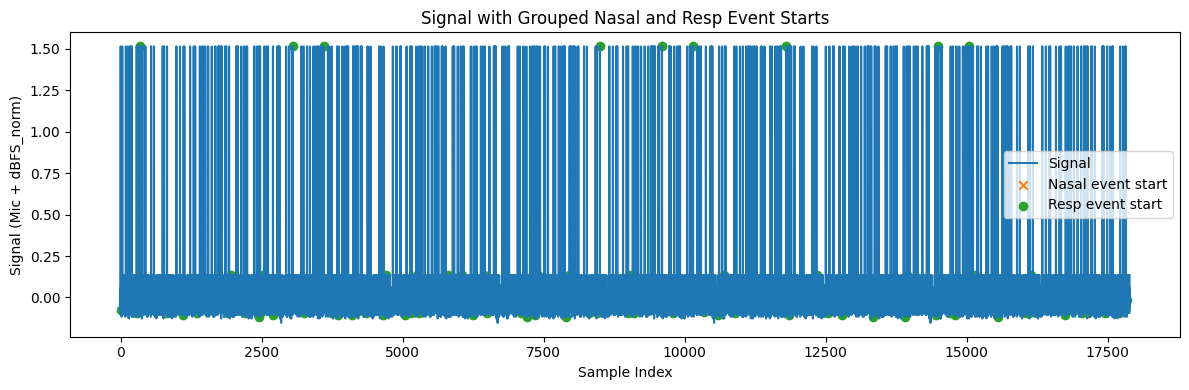

Nasal event start indices: []
Resp event start indices:  [    0    49    99   149   199   249   299   349   399   449   499   549
   599   649   699   749   799   849   899   949   999  1049  1099  1149
  1199  1249  1299  1349  1399  1449  1499  1549  1599  1649  1699  1749
  1799  1849  1899  1949  1999  2049  2099  2149  2199  2249  2299  2349
  2399  2449  2499  2549  2599  2649  2699  2749  2799  2849  2899  2949
  2999  3049  3099  3149  3199  3249  3299  3349  3399  3449  3499  3549
  3599  3649  3699  3749  3799  3849  3899  3949  3999  4049  4099  4149
  4199  4249  4299  4349  4399  4449  4499  4549  4599  4649  4699  4749
  4799  4849  4899  4949  4999  5049  5099  5149  5199  5249  5299  5349
  5399  5449  5499  5549  5599  5649  5699  5749  5799  5849  5899  5949
  5999  6049  6099  6149  6199  6249  6299  6349  6399  6449  6499  6549
  6599  6649  6699  6749  6799  6849  6899  6949  6999  7049  7099  7149
  7199  7249  7299  7349  7399  7449  7499  7549  7599  7649  7699 

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load inference results
df = pd.read_csv('inference_ensemble.csv')
df['sample_idx'] = np.arange(len(df))

# Identify start of each contiguous run for nasal and resp
df['nasal_prev'] = df['pred_nasal'].shift(1, fill_value=0)
df['resp_prev']  = df['pred_resp'].shift(1, fill_value=0)

# A run starts when current==1 and previous==0
nasal_starts = df.index[(df['pred_nasal'] == 1) & (df['nasal_prev'] == 0)].to_numpy()
resp_starts  = df.index[(df['pred_resp']  == 1) & (df['resp_prev']  == 0)].to_numpy()

# Plot the signal
plt.figure(figsize=(12, 4))
plt.plot(df['sample_idx'], df['Mic_plus_dBFS'], label='Signal')

# Mark grouped events at start of each run
plt.scatter(nasal_starts, df.loc[nasal_starts, 'Mic_plus_dBFS'],
            marker='x', color='tab:orange', label='Nasal event start')
plt.scatter(resp_starts, df.loc[resp_starts, 'Mic_plus_dBFS'],
            marker='o', color='tab:green', label='Resp event start')

plt.legend()
plt.xlabel('Sample Index')
plt.ylabel('Signal (Mic + dBFS_norm)')
plt.title('Signal with Grouped Nasal and Resp Event Starts')
plt.tight_layout()
plt.show()

# Output the event start indices as confirmation
print("Nasal event start indices:", nasal_starts)
print("Resp event start indices: ", resp_starts)
